In [19]:
%load_ext autoreload
%autoreload 2

In [30]:
import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import sklearn.linear_model
import scipy.optimize
import sklearn.decomposition
import sklearn.manifold
import sklearn.model_selection
# Libraries for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.manifold

sns.set_context('poster')

In [31]:
import hchs_data_pre_processing
import hchs_transformations
import simclr_models
import simclr_utitlities

In [32]:
working_directory = 'test_run_hchs'
dataset_save_path = os.path.join(os.getcwd(), "PickledData", "hchs")
user_datasets_path = os.path.join(dataset_save_path, "pid_to_data_label_dict.pickle")
user_dataset_resized_path = os.path.join(dataset_save_path, "user_dataset_resized.pickle")
path_to_test_train_split_dict = os.path.join(dataset_save_path, "test_train_split_dict.pickle")
path_to_reduced_test_train_split_dict = os.path.join(dataset_save_path, "reduced_test_train_split_dict.pickle")
sample_key = 163225
path_to_np_train = os.path.join(dataset_save_path, "np_train.pickle")
path_to_np_test = os.path.join(dataset_save_path, "np_test.pickle")
path_to_np_val = os.path.join(dataset_save_path, "np_val.pickle")
path_to_baseline_sueno_merge_no_na = os.path.join(dataset_save_path, "baseline_sueno_merge_no_na.pickle")

# Load hchs data from pickle path

In [33]:
# with open(user_datasets_path, 'rb') as f:
#     user_datasets = pickle.load(f)

In [34]:
# user_datasets_resized = {}

# for user, user_data_labels in user_datasets.items():
#     user_data = user_data_labels[0]
#     user_labels = user_data_labels[1]
#     print(user_data.shape, user_labels.shape, user)
#     new_data = np.array(user_data.values.tolist())[:, :-1].astype(np.float64)
#     new_labels = np.array([label[0] for label in user_labels.values.tolist()])
#     user_datasets_resized[user] = [new_data, new_labels]

In [35]:
# with open(user_dataset_resized_path, 'wb') as f:
#     pickle.dump(user_datasets_resized, f)

In [36]:
with open(user_dataset_resized_path, 'rb') as f:
    user_datasets = pickle.load(f)

In [37]:
len(user_datasets.keys())

1886

# Pre Processing

In [38]:
# Parameters
window_size = 500
input_shape = (window_size, 5)

# Dataset Metadata 
transformation_multiple = 1
dataset_name = 'hchs.pkl'
dataset_name_user_split = 'hchs_user_split.pkl'

label_list = ["ACTIVE", "REST", "REST-S"]
label_list_full_name = label_list
has_null_class = False

label_map = dict([(l, i) for i, l in enumerate(label_list)])

output_shape = len(label_list)

model_save_name = f"hchs_acc"

sampling_rate = 50.0
unit_conversion = scipy.constants.g

# a fixed user-split

with open(path_to_reduced_test_train_split_dict, 'rb') as f:
    test_train_user_dict = pickle.load(f)

test_users = test_train_user_dict['test']
train_users = test_train_user_dict['train']

reduced_user_datasets = {}
for user, data in user_datasets.items():
    if user in test_users or user in train_users:
        reduced_user_datasets[user] = data

print(len(reduced_user_datasets.keys()))
    

print(f'Test Numbers: {len(test_users)}, Train Numbers: {len(train_users)}')

10
Test Numbers: 2, Train Numbers: 8


In [39]:
np_train, np_val, np_test = hchs_data_pre_processing.pre_process_dataset_composite(
    # user_datasets=user_datasets,
    user_datasets=reduced_user_datasets, 
    label_map=label_map, 
    output_shape=output_shape, 
    train_users=train_users, 
    test_users=test_users, 
    window_size=window_size, 
    shift=window_size//2, 
    normalise_dataset=True, 
    verbose=1
)

step 1 done
step 2 done
step 3 done
Test
(array(['ACTIVE', 'REST-S'], dtype='<U6'), array([101,  58], dtype=int64))
(array([0, 2]), array([101,  58], dtype=int64))
-----------------
Train
(array(['ACTIVE', 'REST-S'], dtype='<U6'), array([424, 211], dtype=int64))
(array([0, 2]), array([424, 211], dtype=int64))
-----------------
step 4 done
step 5 done
(508, 500, 5)
(127, 500, 5)
(159, 500, 5)
step 6 done


In [40]:
# with open(path_to_np_train, 'wb') as f:
#     pickle.dump(np_train, f)
# with open(path_to_np_test, 'wb') as f:
#     pickle.dump(np_test, f)
# with open(path_to_np_val, 'wb') as f:
#     pickle.dump(np_val, f)

## SimCLR Training

In [41]:
batch_size = 512
decay_steps = 1000
# epochs = 200
epochs = 3
temperature = 0.1
trasnformation_indices = [1, 2] # Use Scaling and rotation trasnformation

transform_funcs_vectorised = [
    hchs_transformations.noise_transform_vectorized, 
    hchs_transformations.scaling_transform_vectorized, 
    # transformations.rotation_transform_vectorized, 
    hchs_transformations.negate_transform_vectorized, 
    hchs_transformations.time_flip_transform_vectorized, 
    hchs_transformations.time_segment_permutation_transform_improved, 
    hchs_transformations.time_warp_transform_low_cost, 
    hchs_transformations.channel_shuffle_transform_vectorized
]
# transform_funcs_names = ['noised', 'scaled', 'rotated', 'negated', 'time_flipped', 'permuted', 'time_warped', 'channel_shuffled']
transform_funcs_names = ['noised', 'scaled', 'negated', 'time_flipped', 'permuted', 'time_warped', 'channel_shuffled']



In [42]:
start_time = datetime.datetime.now()
start_time_str = start_time.strftime("%Y%m%d-%H%M%S")
tf.keras.backend.set_floatx('float32')

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)
transformation_function = simclr_utitlities.generate_combined_transform_function(transform_funcs_vectorised, indices=trasnformation_indices)

base_model = simclr_models.create_base_model(input_shape, model_name="base_model")
simclr_model = simclr_models.attach_simclr_head(base_model)
simclr_model.summary()

trained_simclr_model, epoch_losses = simclr_utitlities.simclr_train_model(simclr_model, np_train[0], optimizer, batch_size, transformation_function, temperature=temperature, epochs=epochs, is_trasnform_function_vectorized=True, verbose=1)

simclr_model_save_path = f"{working_directory}{start_time_str}_simclr.hdf5"
trained_simclr_model.save(simclr_model_save_path)



<function scaling_transform_vectorized at 0x000002445903BAF0>
<function negate_transform_vectorized at 0x000002445903BB80>
Model: "base_model_simclr"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 500, 5)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 477, 32)           3872      
_________________________________________________________________
dropout (Dropout)            (None, 477, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 462, 64)           32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 462, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 455, 96)           492

## Linear Model

In [43]:
total_epochs = 3
# total_epochs = 50
batch_size = 200
tag = "linear_eval"

simclr_model = tf.keras.models.load_model(simclr_model_save_path)
linear_evaluation_model = simclr_models.create_linear_model_from_base_model(simclr_model, output_shape, intermediate_layer=7)

best_model_file_name = f"{working_directory}{start_time_str}_simclr_{tag}.hdf5"
best_model_callback = tf.keras.callbacks.ModelCheckpoint(best_model_file_name,
    monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=0
)

training_history = linear_evaluation_model.fit(
    x = np_train[0],
    y = np_train[1],
    batch_size=batch_size,
    shuffle=True,
    epochs=total_epochs,
    callbacks=[best_model_callback],
    validation_data=np_val
)

best_model = tf.keras.models.load_model(best_model_file_name)

print("Model with lowest validation Loss:")
print(simclr_utitlities.evaluate_model_simple(best_model.predict(np_test[0]), np_test[1], return_dict=True))
print("Model in last epoch")
print(simclr_utitlities.evaluate_model_simple(linear_evaluation_model.predict(np_test[0]), np_test[1], return_dict=True))


Epoch 1/3
3/3 [==============================] - 1s 320ms/step - loss: 1.0815 - categorical_accuracy: 0.7165 - auc: 0.8118 - precision: 0.7577 - recall: 0.3878 - val_loss: 0.6948 - val_categorical_accuracy: 0.6693 - val_auc: 0.8999 - val_precision: 0.8500 - val_recall: 0.6693
Epoch 2/3
3/3 [==============================] - 0s 129ms/step - loss: 0.6109 - categorical_accuracy: 0.6713 - auc: 0.9081 - precision: 0.8240 - recall: 0.6634 - val_loss: 0.5755 - val_categorical_accuracy: 0.8425 - val_auc: 0.9284 - val_precision: 0.8586 - val_recall: 0.6693
Epoch 3/3
3/3 [==============================] - 0s 125ms/step - loss: 0.5322 - categorical_accuracy: 0.8130 - auc: 0.9317 - precision: 0.8380 - recall: 0.6516 - val_loss: 0.5699 - val_categorical_accuracy: 0.8504 - val_auc: 0.9285 - val_precision: 0.8586 - val_recall: 0.6693
Model with lowest validation Loss:
{'Confusion Matrix': array([[99,  2],
       [25, 33]], dtype=int64), 'F1 Macro': 0.7948387096774194, 'F1 Micro': 0.8301886792452831, 

# Window-Level to User-Level Embeddings

In [44]:
target_model = simclr_model 
intermediate_model = simclr_models.extract_intermediate_model_from_base_model(target_model, intermediate_layer=7)
intermediate_model.summary()

embeddings = intermediate_model.predict(np_test[0], batch_size=batch_size)

Model: "base_model_simclr_layer_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 500, 5)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 477, 32)           3872      
_________________________________________________________________
dropout (Dropout)            (None, 477, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 462, 64)           32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 462, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 455, 96)           49248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 455, 

In [45]:
user_datasets_windowed = hchs_data_pre_processing.get_windows_dataset_from_user_list_format(user_datasets, window_size, shift=window_size//2)
train_x, train_y, test_x, test_y = hchs_data_pre_processing.combine_windowed_dataset(user_datasets_windowed, train_users, test_users)

In [46]:
total_length = 0

for user in user_datasets_windowed.keys():
    if user in test_users:
        total_length += user_datasets_windowed[user][0].shape[0]

print(total_length)

159


In [47]:
test_user_window_list = []
for user in user_datasets_windowed.keys():
    if user in test_users:
        user_to_add = [user] * user_datasets_windowed[user][0].shape[0]
        test_user_window_list += user_to_add

In [48]:
embeddings_dataframe = pd.DataFrame(embeddings)
# embeddings_dataframe['user'] = test_user_window_list
embeddings_dataframe.index = test_user_window_list
user_level_activations = embeddings_dataframe.groupby(embeddings_dataframe.index).mean()
user_level_activations_x = user_level_activations.shape[0]
user_level_activations_y = user_level_activations.shape[1]

In [49]:
user_level_activations

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
13151529,3.240394,0.233922,0.815657,0.409711,0.187438,0.245699,0.019450,0.950534,0.001092,0.025740,...,1.967225,6.858905,0.205626,2.316396,0.042064,0.117874,0.001366,1.598977,0.087515,0.021122
82056021,4.710656,0.198849,1.168390,0.506425,0.209499,0.310902,0.013729,1.257404,0.002649,0.026706,...,2.705784,9.959938,0.231816,3.394259,0.040237,0.136909,0.003830,2.098455,0.098415,0.022066


# tSNE with user level activations

In [50]:
disease_labels = {'diabetes': {1: 'Non-diabetic', 2: 'Pre-diabetic', 3: 'Diabetic'}, 'sleep_apnea': {0: 'No', 1: 'Yes'}, 'hypertension': {0: 'No', 1: 'Yes'}, 'metabolic_syndrome': {0: 'No', 1: 'Yes'}, 'insomnia': {1: 'No clinically significant insomnia', 2: 'Subthreshold insomnia', 3: 'Clinical insomnia'}, 'gender': {0: 'female', 1: 'male'}}

baseline_sueno_merged_no_na = pd.read_pickle(path_to_baseline_sueno_merge_no_na)
test_baseline_sueno_merged_no_na_mask = baseline_sueno_merged_no_na.index.isin(test_users)
test_baseline_sueno_merged_no_na = baseline_sueno_merged_no_na[test_baseline_sueno_merged_no_na_mask]
test_baseline_sueno_merged_no_na.shape

(1, 10)

In [51]:
user_level_activation_no_na_mask = user_level_activations.index.isin(test_baseline_sueno_merged_no_na.index)
user_level_activation_no_na = user_level_activations[user_level_activation_no_na_mask]
user_level_activation_no_na.shape

(1, 96)

In [52]:
X = user_level_activations.values
print(X.shape)
for k in range(user_level_activations_y):
    std = np.std(X[:,k])
    if std==0.0:
        continue
    else:
        X[:,k] = (X[:,k] / np.std(X[:,k]))
print(np.any(np.isnan(X)))
print(np.all(np.isfinite(X)))

(2, 96)
False
True


In [53]:
tsne = sklearn.manifold.TSNE(n_components=2, verbose=1, perplexity=50)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 1 nearest neighbors...
[t-SNE] Indexed 2 samples in 0.000s...
[t-SNE] Computed neighbors for 2 samples in 0.199s...
[t-SNE] Computed conditional probabilities for sample 2 / 2
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 29.818880
[t-SNE] KL divergence after 300 iterations: 0.000000


(2,)

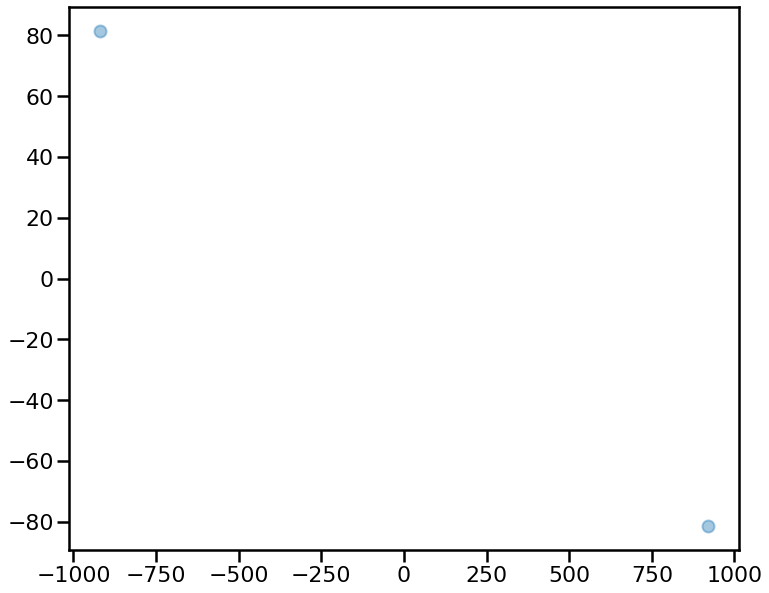

In [54]:
p1,p2 = tsne_results[:,0], tsne_results[:,1]
fig,ax = plt.subplots(figsize=(12,10))
ax.scatter(p1, p2, alpha=.4)

p1.shape

In [55]:
def plot_tsne_color_coded_by_condition(disease, perplexity,disease_labels):
    labels_full_name = disease_labels[disease]
    distinct_condition_values = np.unique(test_baseline_sueno_merged_no_na[disease])
    distinct_colors = sns.color_palette("hsv", len(distinct_condition_values))
    color_dict = {condition:color for condition, color in zip(distinct_condition_values, distinct_colors)}
    cvec = [color_dict[c] for c in test_baseline_sueno_merged_no_na[disease]]
    print(len(cvec))
    
    X = user_level_activation_no_na.values
    print(X.shape)
    for k in range(user_level_activations_y):
        std = np.std(X[:,k])
        if std==0.0:
            continue
        else:
            X[:,k] = (X[:,k] / np.std(X[:,k]))

    tsne = sklearn.manifold.TSNE(n_components=2, verbose=1, perplexity=perplexity)
    tsne_results = tsne.fit_transform(X)

    p1,p2 = tsne_results[:,0], tsne_results[:,1]

    fig,ax = plt.subplots(figsize=(12,10))
    ax.scatter(p1, p2, alpha=.4,c=cvec)
    # Force the plot to have equal aspect ratio, i.e. one unit on the x-axis = one unit on the y-axis
    ax.set_aspect('equal')

    markers = [plt.Line2D([0,0],[0,0],color=color, alpha=.5, marker='o', linestyle='', ms=10) for color in color_dict.values()]
    ax.legend(markers, labels_full_name.values(), numpoints=1, fontsize=10)


    plt.title("tSNE colour coded by " + disease + " at perplexity:" + str(perplexity), fontsize=15)
    plt.show()
    

In [56]:
plot_tsne_color_coded_by_condition('hypertension', 30, disease_labels)

1
(1, 96)


ValueError: Found array with 1 sample(s) (shape=(1, 96)) while a minimum of 2 is required.

# Classification using embeddings
### using the user level embeddings, we can train a neural net to perform downstream tasks, such as predicting the various diseases 

In [57]:
user_datasets_windowed = hchs_data_pre_processing.get_windows_dataset_from_user_list_format(user_datasets, window_size, shift=window_size//2)
train_x, train_y, test_x, test_y = hchs_data_pre_processing.combine_windowed_dataset(user_datasets_windowed, train_users, test_users)

test_user_window_list = []
train_user_window_list = []
for user in user_datasets_windowed.keys():
    user_to_add = [user] * user_datasets_windowed[user][0].shape[0]
    if user in test_users:
        test_user_window_list += user_to_add

    if user in train_users:
        train_user_window_list += user_to_add

print(len(test_user_window_list))
print(len(train_user_window_list))

159
635


In [63]:
train_user_window_list, val_user_window_list, _, _ = sklearn.model_selection.train_test_split(train_user_window_list, train_user_window_list, test_size=0.20, random_state=42)

In [64]:
print(len(train_user_window_list))
print(len(val_user_window_list))

508
127


In [65]:
target_model = simclr_model 
intermediate_model = simclr_models.extract_intermediate_model_from_base_model(target_model, intermediate_layer=7)
intermediate_model.summary()

embeddings_test = intermediate_model.predict(np_test[0], batch_size=batch_size)
embeddings_train = intermediate_model.predict(np_train[0], batch_size=batch_size)
embeddings_val = intermediate_model.predict(np_val[0], batch_size=batch_size)

Model: "base_model_simclr_layer_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 500, 5)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 477, 32)           3872      
_________________________________________________________________
dropout (Dropout)            (None, 477, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 462, 64)           32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 462, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 455, 96)           49248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 455, 

In [62]:
embeddings_train.shape

(508, 96)

In [66]:
embeddings_test_dataframe = pd.DataFrame(embeddings_test)
embeddings_train_dataframe = pd.DataFrame(embeddings_train)
embeddings_val_dataframe = pd.DataFrame(embeddings_val)
# embeddings_dataframe['user'] = test_user_window_list
embeddings_test_dataframe.index = test_user_window_list
embeddings_train_dataframe.index = train_user_window_list
embeddings_val_dataframe.index = val_user_window_list

user_level_activations_test = embeddings_test_dataframe.groupby(embeddings_test_dataframe.index).mean()
user_level_activations_train = embeddings_train_dataframe.groupby(embeddings_train_dataframe.index).mean()
user_level_activations_val = embeddings_val_dataframe.groupby(embeddings_val_dataframe.index).mean()

In [67]:
baseline_sueno_merged_no_na = pd.read_pickle(path_to_baseline_sueno_merge_no_na)

test_baseline_sueno_merged_no_na_mask = baseline_sueno_merged_no_na.index.isin(set(test_user_window_list))
test_baseline_sueno_merged_no_na = baseline_sueno_merged_no_na[test_baseline_sueno_merged_no_na_mask]

train_baseline_sueno_merged_no_na_mask = baseline_sueno_merged_no_na.index.isin(set(train_user_window_list))
train_baseline_sueno_merged_no_na = baseline_sueno_merged_no_na[train_baseline_sueno_merged_no_na_mask]

val_baseline_sueno_merged_no_na_mask = baseline_sueno_merged_no_na.index.isin(set(val_user_window_list))
val_baseline_sueno_merged_no_na = baseline_sueno_merged_no_na[val_baseline_sueno_merged_no_na_mask]

In [82]:
user_level_activation_no_na_mask_test = user_level_activations_test.index.isin(list(test_baseline_sueno_merged_no_na.index))
user_level_activation_no_na_test = user_level_activations_test[user_level_activation_no_na_mask_test]

user_level_activation_no_na_mask_train = user_level_activations_train.index.isin(train_baseline_sueno_merged_no_na.index)
user_level_activation_no_na_train = user_level_activations_train[user_level_activation_no_na_mask_train]

user_level_activation_no_na_mask_val = user_level_activations_val.index.isin(val_baseline_sueno_merged_no_na.index)
user_level_activation_no_na_val = user_level_activations_val[user_level_activation_no_na_mask_val]

In [83]:
def get_train_valid_test_x_y_for_disease(disease, user_level_activation_no_na_train, user_level_activation_no_na_val, user_level_activation_no_na_test, 
                                        train_baseline_sueno_merged_no_na, val_baseline_sueno_merged_no_na, test_baseline_sueno_merged_no_na):
    train_x = user_level_activation_no_na_train.values.tolist()
    val_x = user_level_activation_no_na_val.values.tolist()
    test_x = user_level_activation_no_na_test.values.tolist()

    train_y = train_baseline_sueno_merged_no_na[disease].values.tolist()
    val_y = val_baseline_sueno_merged_no_na[disease].values.tolist()
    test_y = test_baseline_sueno_merged_no_na[disease].values.tolist()

    return train_x, val_x, test_x, train_y, val_y, test_y

In [84]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [85]:
disease = 'diabetes'
train_x, val_x, test_x, train_y, val_y, test_y = get_train_valid_test_x_y_for_disease(disease, user_level_activation_no_na_train, user_level_activation_no_na_val, user_level_activation_no_na_test, train_baseline_sueno_merged_no_na, val_baseline_sueno_merged_no_na, test_baseline_sueno_merged_no_na)

In [88]:
X_train = np.array(train_x)
X_test = np.array(test_x)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = np.array(train_y)
y_test = np.array(test_y)

In [90]:
svc = SVC(kernel='linear')
svc.fit(X_train_scaled, y_train)
predictions = svc.predict(X_test_scaled)

In [91]:
predictions

array([2.])